<a href="https://colab.research.google.com/github/anshupandey/xebia_training_data/blob/main/Object_Localization_xebia_13_03_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

In [1]:
!wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

In [2]:
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null; echo " done."

 done.


In [3]:
!wget -q https://raw.githubusercontent.com/anshupandey/Computer-Vision/master/Object%20Localization/PASCAL_VOC_labels.p

## Data Processing

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet50


In [5]:
df = pd.read_pickle("/content/PASCAL_VOC_labels.p")
df.shape

(2501, 4)

In [6]:
df.head()

,file_name,category,cat_id,bbox
0,12,car,7,"[96, 155, 269, 350]"
1,17,horse,13,"[77, 89, 335, 402]"
2,23,person,15,"[1, 2, 461, 242]"
3,26,car,7,"[124, 89, 211, 336]"
4,32,aeroplane,1,"[77, 103, 182, 374]"


In [7]:
df['file_name'] = df['file_name'].astype(str)
df['file_name'] = df['file_name'].str.zfill(6)
df['file_name'] = df['file_name'].apply(lambda x:x+".jpg")
df.head()

,file_name,category,cat_id,bbox
0,000012.jpg,car,7,"[96, 155, 269, 350]"
1,000017.jpg,horse,13,"[77, 89, 335, 402]"
2,000023.jpg,person,15,"[1, 2, 461, 242]"
3,000026.jpg,car,7,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,1,"[77, 103, 182, 374]"


(500, 334, 3)


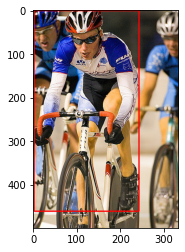

In [12]:
main_folder = "/content/VOCdevkit/VOC2007/JPEGImages/"
img = plt.imread(main_folder+df['file_name'][2])
print(img.shape)
bb = df['bbox'][2]
cv2.rectangle(img,(bb[1],bb[0]),(bb[3],bb[2]),[255,0,0],2)

plt.imshow(img)
plt.show()

In [17]:
print(img.shape)
print(bb)

(500, 334, 3)
[  1   2 461 242]


In [14]:
import imgaug as ig
from imgaug import augmenters as ag

In [16]:
aug = ag.Resize({"height":150,"width":150}).to_deterministic()
bb = df['bbox'][2]
old_bb = ig.BoundingBoxesOnImage([ig.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2=bb[2])],shape=img.shape)
new_img = aug.augment_images([img])[0]
new_bb = aug.augment_bounding_boxes([old_bb])[0]
print(new_img.shape)
print(new_bb)

(150, 150, 3)
BoundingBoxesOnImage([BoundingBox(x1=0.8982, y1=0.3000, x2=108.6826, y2=138.3000, label=None)], shape=(150, 150, 3))


In [25]:
def transform_bb(img,bb):
  aug = ag.Resize({"height":150,"width":150}).to_deterministic()
  old_bb = ig.BoundingBoxesOnImage([ig.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2=bb[2])],shape=img.shape)
  new_img = aug.augment_images([img])[0]
  new_bb = aug.augment_bounding_boxes([old_bb])[0].bounding_boxes[0]
  new_bb = [new_bb.x1,new_bb.y1,new_bb.x2,new_bb.y2]
  return new_img,new_bb


In [26]:
sorted(df['cat_id'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [23]:
df['cat_id'] = df['cat_id']-1

In [27]:
x = []
y1 = []
y2 = []

for i in range(df.shape[0]):
  img = plt.imread(main_folder+df['file_name'][i])
  img,bb = transform_bb(img,df['bbox'][i])
  img = resnet50.preprocess_input(img)
  x.append(img)
  y1.append(df['cat_id'][i])
  y2.append(bb)

In [29]:
from tensorflow.keras.utils import to_categorical
x = np.array(x)
print(x.shape)
y1 = to_categorical(y1)
print(y1.shape)
y2 = np.array(y2)
print(y2.shape)

(2501, 150, 150, 3)
(2501, 20)
(2501, 4)


# Modelling using Transfer Learning

In [36]:
from tensorflow.keras import models,layers

In [60]:
input_layer = layers.Input(shape=(150,150,3))
res_model = resnet50.ResNet50(weights='imagenet',include_top=False,input_tensor=input_layer)


for layer in res_model.layers[:-8]:
  layer.trainable=False

current_last_layer = res_model.output
#add a flatten layer
ft = layers.Flatten()(current_last_layer)

# classification segment
cf = layers.Dropout(0.5)(ft)
cf = layers.Dense(128,activation='relu')(cf)
cf = layers.Dropout(0.2)(cf)
output1 = layers.Dense(20,activation='softmax',name='classification')(cf)

# regression segment
rg = layers.Dropout(0.5)(ft)
rg = layers.Dense(128,activation='relu')(rg)
rg = layers.Dropout(0.2)(rg)
output2 = layers.Dense(4,activation='relu',name='regression')(rg)

model = models.Model(inputs=input_layer,outputs=[output1,output2])

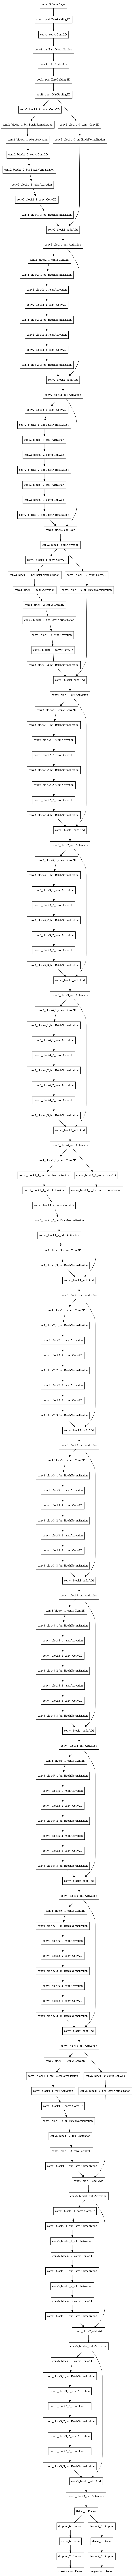

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [62]:
model.compile(loss={'classification':'categorical_crossentropy','regression':'mae'},optimizer='adam',metrics={"classification":'accuracy'},
              loss_weights={'regression':1,'classification':4})
model.fit(x=x,y=[y1,y2],epochs=20,batch_size=128,shuffle=True,validation_split=0.2)

Epoch 1/20
16/16 [==============================] - 6s 206ms/step - loss: 68.0702 - classification_loss: 5.7928 - regression_loss: 44.8988 - classification_accuracy: 0.3463 - val_loss: 37.6526 - val_classification_loss: 2.1639 - val_regression_loss: 28.9969 - val_classification_accuracy: 0.3713
Epoch 2/20
16/16 [==============================] - 2s 146ms/step - loss: 24.2782 - classification_loss: 0.8874 - regression_loss: 20.7285 - classification_accuracy: 0.7347 - val_loss: 52.5880 - val_classification_loss: 2.8350 - val_regression_loss: 41.2481 - val_classification_accuracy: 0.4611
Epoch 3/20
16/16 [==============================] - 2s 146ms/step - loss: 19.7439 - classification_loss: 0.3934 - regression_loss: 18.1702 - classification_accuracy: 0.8636 - val_loss: 31.7920 - val_classification_loss: 1.5942 - val_regression_loss: 25.4153 - val_classification_accuracy: 0.6108
Epoch 4/20
16/16 [==============================] - 2s 146ms/step - loss: 17.3379 - classification_loss: 0.2293 

In [53]:
!wget -q https://cars.usnews.com/pics/size/640x420/static/images/article/202002/128389/1_title_2020_kia_optima.jpg

^C


In [69]:
img = image.load_img("/content/hero_landscape_91e1b039-11ef-4d97-a01e-639b6ee4990a.jpg",target_size=(150,150))
img = image.img_to_array(img)
img.shape

(150, 150, 3)

In [70]:
img2 = img.copy()
img2 = resnet50.preprocess_input(img2)
prediction = model.predict(img2.reshape(1,150,150,3))
prediction

[array([[2.5460276e-09, 1.4096664e-10, 4.1641650e-09, 7.8429329e-12,
         4.7582986e-07, 1.9293975e-09, 2.7827810e-10, 5.1840954e-10,
         1.9462667e-09, 4.9731619e-09, 1.6201913e-09, 1.2309650e-09,
         5.1762264e-08, 2.7024043e-07, 9.9999917e-01, 6.5072375e-10,
         4.1359463e-09, 6.4065757e-09, 1.4762296e-11, 6.9878079e-12]],
       dtype=float32),
 array([[ 37.48963  ,   2.1299322, 107.76609  , 124.07935  ]],
       dtype=float32)]

14
['person']


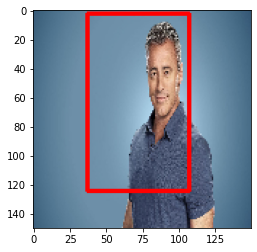

In [71]:
cls = np.argmax(prediction[0])
bb = prediction[1][0]
print(cls)
print(df['category'][df['cat_id']==cls].unique())
cv2.rectangle(img,(bb[0],bb[1]),(bb[2],bb[3]),[255,0,0],2)
plt.imshow(img.astype('int32'))
plt.show()